In [1]:
pip install pandas pyarrow plotly kaleido altair vega_datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
parquetPath = '/home/jovyan/work/output/Experience-20-D2_60-weatherDepthHours_3_0/data/joined_exploded_data.parquet'
df = pd.read_parquet(parquetPath)  # pyarrow recommandé
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/work/output/Experience-20-D2_60-weatherDepthHours_3-0/data/joined_exploded_data.parquet'

In [9]:
# 🔹 Afficher joliment
for col in df.columns:
    print(col)


CRS_DEP_TIME
CRS_ELAPSED_TIME
DEST_AIRPORT_ID
DEST_WBAN
OP_CARRIER_AIRLINE_ID
ORIGIN_AIRPORT_ID
ORIGIN_WBAN
PREV_AIRCRAFT_ARR_DELAY
UTC_FL_DATE
feature_arrival_time_period
feature_avg_delay
feature_departure_hour_rounded
feature_departure_time_period
feature_flight_week_of_year
feature_turnaround_buffer
feature_utc_departure_hour_rounded
is_delayed
origin_weather_WindDirection-3
origin_weather_PressureChange-3
origin_weather_feature_pressure_bucket-3
origin_weather_has_hail-3
origin_weather_DewPointFarenheit-3
origin_weather_has_visible_moisture-3
origin_weather_WetBulbCelsius-3
origin_weather_feature_flight_category-3
origin_weather_DryBulbFarenheit-3
origin_weather_weather_hazard_level-3
origin_weather_feature_weather_severity_index-3
origin_weather_has_obscuration-3
origin_weather_feature_visibility_miles-3
origin_weather_has_precipitation-3
origin_weather_RelativeHumidity-3
origin_weather_feature_visibility_category-3
origin_weather_weather_intensity-3
origin_weather_feature_has_br

In [10]:
num_cols = [c for c in df.columns if df[c].dtype != "object" and c != "is_delayed"]
cat_cols = [c for c in df.columns if df[c].dtype == "object"]

print(cat_cols)

['DEST_WBAN', 'ORIGIN_WBAN', 'UTC_FL_DATE', 'feature_arrival_time_period', 'feature_departure_time_period', 'origin_weather_feature_pressure_bucket-3', 'origin_weather_feature_flight_category-3', 'origin_weather_feature_visibility_category-3', 'origin_weather_weather_intensity-3', 'origin_weather_extracted_codes-3', 'origin_weather_ValueForWindCharacter-3', 'origin_weather_feature_most_critical_sky-3', 'origin_weather_PressureTendency-3', 'origin_weather_feature_pressure_bucket-2', 'origin_weather_feature_flight_category-2', 'origin_weather_feature_visibility_category-2', 'origin_weather_weather_intensity-2', 'origin_weather_extracted_codes-2', 'origin_weather_ValueForWindCharacter-2', 'origin_weather_feature_most_critical_sky-2', 'origin_weather_PressureTendency-2', 'origin_weather_feature_pressure_bucket-1', 'origin_weather_feature_flight_category-1', 'origin_weather_feature_visibility_category-1', 'origin_weather_weather_intensity-1', 'origin_weather_extracted_codes-1', 'origin_weat

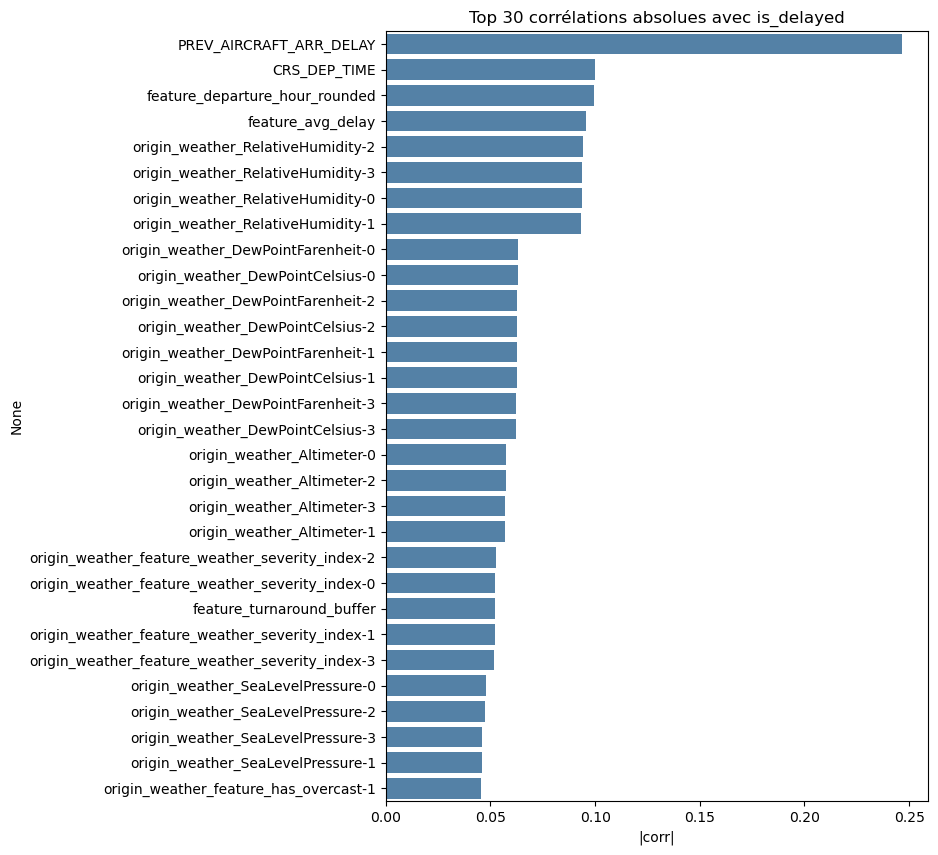

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

corrs = df[num_cols].corrwith(df["is_delayed"]).abs().sort_values(ascending=False)
top_corrs = corrs.head(30)
plt.figure(figsize=(7,10))
sns.barplot(x=top_corrs.values, y=top_corrs.index, color="steelblue")
plt.title("Top 30 corrélations absolues avec is_delayed")
plt.xlabel("|corr|")
plt.show()

In [12]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

X_cat = df[cat_cols].fillna("NA").apply(LabelEncoder().fit_transform)
y = df["is_delayed"]

chi2_vals, pvals = chi2(X_cat, y)
chi2_result = pd.DataFrame({"feature": cat_cols, "chi2": chi2_vals, "pval": pvals})
chi2_result.sort_values("chi2", ascending=False).head(20)

feature           chi2  pval
17              origin_weather_extracted_codes-2  108064.490851   0.0
25              origin_weather_extracted_codes-1   97427.561208   0.0
33              origin_weather_extracted_codes-0   85200.540648   0.0
9               origin_weather_extracted_codes-3   84079.618178   0.0
0                                      DEST_WBAN    4897.441572   0.0
4                  feature_departure_time_period    3934.087092   0.0
3                    feature_arrival_time_period    3730.730895   0.0
2                                    UTC_FL_DATE    3200.581587   0.0
15  origin_weather_feature_visibility_category-2    2500.992637   0.0
36             origin_weather_PressureTendency-0    2420.890672   0.0
31  origin_weather_feature_visibility_category-0    2357.338778   0.0
7   origin_weather_feature_visibility_category-3    2298.655349   0.0
23  origin_weather_feature_visibility_category-1    2279.997899   0.0
1                                    ORIGIN_WBAN    2208.859186   0.0
28             origin_weather_PressureTendency-1    1906.050675   0.0
20             origin_weather_PressureTendency-2    1874.651737   0.0
14      origin_weather_feature_flight_category-2    1581.296060   0.0
12             origin_weather_PressureTendency-3    1483.910513   0.0
6       origin_weather_feature_flight_category-3    1481.244156   0.0
22      origin_weather_feature_flight_category-1    1478.633171   0.0

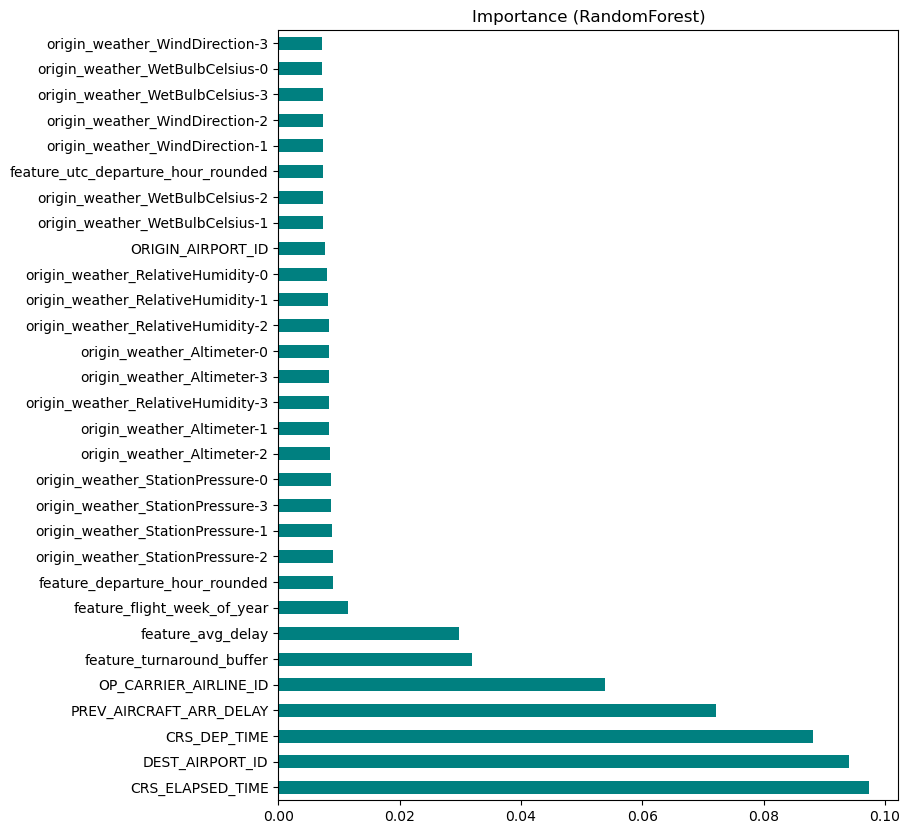

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df[num_cols].fillna(0)
y = df["is_delayed"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=num_cols)
top_features = importances.sort_values(ascending=False).head(30)
top_features.plot(kind="barh", figsize=(8,10), color="teal")
plt.title("Importance (RandomForest)")
plt.show()

In [15]:
feature_groups = (
    pd.DataFrame({
        "feature": importances.index,
        "importance": importances.values
    })
    .assign(
        loc=lambda d: d["feature"].str.extract(r"^(origin|destination)")[0],
        hour_shift=lambda d: d["feature"].str.extract(r"-(\d)$")[0],
        var=lambda d: d["feature"]
            .str.replace(r"^(origin_weather_|destination_weather_)", "", regex=True)
            .str.replace(r"-\d$", "", regex=True)
    )
)

# Importance moyenne par variable météo
agg = (feature_groups
       .groupby(["var", "loc"])
       ["importance"].mean()
       .reset_index()
       .sort_values("importance", ascending=False))
agg.head(20)

var     loc  importance
11                    StationPressure  origin    0.008818
0                           Altimeter  origin    0.008384
9                    RelativeHumidity  origin    0.008219
12                     WetBulbCelsius  origin    0.007336
14                      WindDirection  origin    0.007226
10                   SeaLevelPressure  origin    0.006932
28        feature_lowest_cloud_height  origin    0.006654
15                          WindSpeed  origin    0.006588
3                      DryBulbCelsius  origin    0.006493
1                     DewPointCelsius  origin    0.006397
4                    DryBulbFarenheit  origin    0.006200
2                   DewPointFarenheit  origin    0.006048
13                   WetBulbFarenheit  origin    0.005311
16                    feature_ceiling  origin    0.004528
39     feature_weather_severity_index  origin    0.003310
17           feature_cloud_risk_score  origin    0.002657
32  feature_pressure_visibility_combo  origin    0.002647
52                   press_change_abs  origin    0.002637
8                      PressureChange  origin    0.002629
29           feature_num_cloud_layers  origin    0.002020

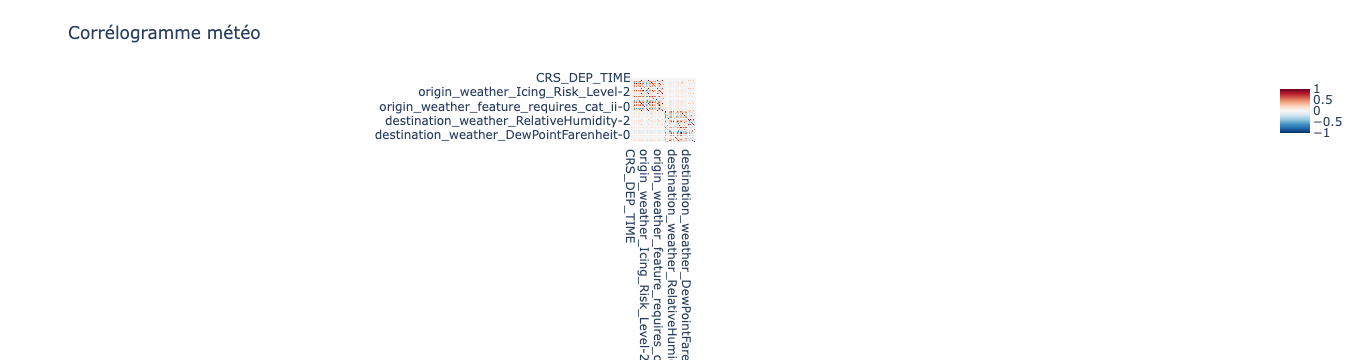

In [13]:
import plotly.express as px
corr = df[[*num_cols, "is_delayed"]].corr()
fig = px.imshow(corr, color_continuous_scale="RdBu_r", title="Corrélogramme météo")
fig.show()